# Importing Libraries

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install scikit-plot
!pip install eli5

In [25]:
import datetime
import warnings
# linear algebra
import numpy as np
# data processing
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from datetime import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import eli5
from eli5.sklearn import PermutationImportance

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import gc
# Enable automatic garbage collection.
gc.enable()
#For Repreduciton the 
seed = 127
np.random.seed(seed)

In [0]:
paribas_data = pd.read_csv('/content/drive/My Drive/Project with Enas Kh/Thesis/Codes and Dataset/AwE/Gender/5_Gender_TFIDFLDA/GenderLDA-TFIDF.csv')

In [42]:
paribas_data.shape

(344, 67)

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
   paribas_data.drop(labels=[], axis=1),
    paribas_data['target'],
    test_size=0.2,
    random_state=41)

# Load & Explore Dataset

In [0]:
#load data
train_df = train_features
test_df = test_features

In [45]:
train_features.shape

(275, 67)

In [46]:
test_features.shape

(69, 67)

In [47]:
#Explore the train data
train_df.head()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
214,215,0,1,1,2,1,2,2,2,1,3,1,0.127995,0.100775,0.105370,0.097846,0.000000,0.106320,0.127995,0.198595,0.127995,0.097272,0.106959,0.106639,0.193973,0.192271,0.127995,0.208240,0.092276,0.139457,0.127995,0.127995,0.317057,0.112943,0.127995,0.106002,0.127995,0.127995,0.127995,0.127995,0.123190,0.127995,0.127995,0.127995,0.127995,0.127995,0.127995,0.127584,0.127995,0.127995,0.000000,0.123190,0.127995,0.139457,0.127995,0.122415,0.127995,0.139457,0.112599,0.127995,0.139457,0.127995,0.124366,0.127995,0.144317,0.144317,0.127995
275,276,1,1,1,1,2,1,4,0,1,0,0,0.000000,0.168935,0.000000,0.164024,0.273794,0.000000,0.000000,0.166458,0.000000,0.326124,0.000000,0.178765,0.162583,0.644630,0.000000,0.000000,0.154688,0.000000,0.000000,0.000000,0.000000,0.189332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206510,0.000000,0.000000,0.000000,0.205211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.241927,0.241927,0.000000
36,37,1,0,1,1,1,0,0,1,3,0,0,0.000000,0.000000,0.167118,0.155184,0.518077,0.168625,0.000000,0.157487,0.000000,0.154274,0.000000,0.000000,0.000000,0.000000,0.000000,0.165135,0.439053,0.000000,0.000000,0.000000,0.000000,0.179129,0.203002,0.000000,0.000000,0.000000,0.203002,0.000000,0.000000,0.203002,0.000000,0.203002,0.000000,0.000000,0.000000,0.202350,0.000000,0.000000,0.249442,0.000000,0.203002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203002,0.000000,0.000000,0.000000
202,203,0,1,1,2,1,2,2,2,1,1,1,0.134128,0.105604,0.110419,0.102534,0.000000,0.111414,0.134128,0.208111,0.134128,0.101932,0.112084,0.111749,0.203267,0.201484,0.134128,0.218218,0.096697,0.146139,0.134128,0.134128,0.110749,0.118355,0.134128,0.111081,0.134128,0.134128,0.134128,0.134128,0.129092,0.134128,0.134128,0.134128,0.134128,0.134128,0.134128,0.133697,0.134128,0.134128,0.000000,0.129092,0.134128,0.146139,0.134128,0.128281,0.134128,0.146139,0.117994,0.134128,0.146139,0.134128,0.130325,0.134128,0.151232,0.151232,0.134128
108,109,0,1,1,2,1,2,2,2,1,1,1,0.132879,0.104620,0.109391,0.101579,0.000000,0.110377,0.132879,0.206173,0.132879,0.100983,0.111041,0.221416,0.201374,0.199608,0.132879,0.216186,0.095797,0.144778,0.132879,0.132879,0.109718,0.117253,0.132879,0.110047,0.132879,0.132879,0.132879,0.132879,0.127891,0.132879,0.132879,0.132879,0.132879,0.132879,0.132879,0.132452,0.132879,0.132879,0.163278,0.127891,0.132879,0.144778,0.132879,0.127086,0.132879,0.144778,0.116896,0.132879,0.144778,0.132879,0.129111,0.132879,0.000000,0.000000,0.132879


In [48]:
#Explore the test data
test_df.head()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
329,330,1,0,1,0,1,0,0,3,2,0,0,0.000000,0.000000,0.000000,0.130045,0.651228,0.282617,0.000000,0.000000,0.000000,0.129283,0.142158,0.000000,0.000000,0.000000,0.000000,0.415154,0.245286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330586,0.000000,0.191810,0.191810,0.000000
261,262,1,1,1,1,2,1,1,2,1,3,1,0.128613,0.101261,0.105879,0.098318,0.328231,0.106833,0.128613,0.099777,0.128613,0.195482,0.107475,0.214307,0.097454,0.096600,0.128613,0.209245,0.092721,0.000000,0.128613,0.128613,0.318586,0.113488,0.128613,0.106514,0.128613,0.128613,0.128613,0.128613,0.123784,0.128613,0.128613,0.128613,0.128613,0.128613,0.128613,0.128200,0.128613,0.128613,0.000000,0.123784,0.128613,0.000000,0.128613,0.123006,0.128613,0.000000,0.113142,0.128613,0.000000,0.128613,0.000000,0.128613,0.145014,0.145014,0.128613
200,201,0,1,2,2,1,2,2,2,1,1,1,0.132062,0.103977,0.108718,0.201908,0.000000,0.109698,0.132062,0.204904,0.132062,0.100362,0.110357,0.110027,0.200135,0.198380,0.132062,0.214856,0.095208,0.143887,0.132062,0.132062,0.109043,0.116531,0.132062,0.109370,0.132062,0.132062,0.132062,0.132062,0.127104,0.132062,0.132062,0.132062,0.132062,0.132062,0.132062,0.131637,0.132062,0.132062,0.000000,0.127104,0.132062,0.143887,0.132062,0.126304,0.132062,0.143887,0.116176,0.132062,0.143887,0.132062,0.128317,0.132062,0.148902,0.148902,0.132062
339,340,0,0,3,2,0,1,0,0,0,1,1,0.000000,0.000000,0.000000,0.411644,0.687131,0.298198,0.000000,0.278502,0.000000,0.000000,0.149996,0.000000,0.136010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148209,0.000000,0.000000,0.148653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157905,0.000000,0.000000,0.000000,0.000000,0.000000,0.202385,0.202385,0.000000
169,170,1,1,1,2,1,2,2,2,1,2,1,0.132923,0.104655,0.109427,0.101612,0.000000,0.110413,0.132923,0.206241,0.132923,0.101016,0.111077,0.110744,0.201440,0.199673,0.132923,0.216257,0.095829,0.144825,0.132923,0.132923,0.219508,0.117291,0.132923,0.110083,0.132923,0.132923,0.132923,0.132923,0.127932,0.132923,0.132923,0.132923,0.132923,0.132923,0.132923,0.132496,0.132923,0.132923,0.163331,0.127932,0.132923,0.144825,0.132923,0.127128,0.132923,0.144825,0.116934,0.132923,0.144825,0.132923,0.129154,0.132923,0.000000,0.000000,0.132923


In [49]:
#Size Dataset
train_df.shape , test_df.shape

((275, 67), (69, 67))

In [50]:
#count of target in train data
train_df.groupby('target').count()['id']

target
0    133
1    142
Name: id, dtype: int64

In [51]:
#data type for train data
pd.DataFrame(train_df.dtypes).transpose()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [52]:
#data type for test data
pd.DataFrame(test_df.dtypes).transpose()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# Check for Missing data & data type

In [53]:
#Finding the missing values in train and test data
train_missing=train_df.isnull().sum().sum()
test_missing=test_df.isnull().sum().sum()
print('Missing values in train data :',train_missing)
print('Missing values in test data :',test_missing)

Missing values in train data : 0
Missing values in test data : 0


# Describe Data

In [54]:
# describe train
train_df.describe()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,275.000000,2.750000e+02,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,275.000000,275.000000,2.750000e+02,2.750000e+02,2.750000e+02,275.000000,275.000000,2.750000e+02,275.000000,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,275.000000,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02,275.000000,275.000000,2.750000e+02,2.750000e+02,2.750000e+02,275.000000,2.750000e+02,2.750000e+02,275.000000,2.750000e+02,2.750000e+02,2.750000e+02,275.000000,2.750000e+02,275.000000,275.000000,2.750000e+02
mean,170.527273,0.516364,1.029091,1.138182,1.494545,1.090909,1.480000,1.494545,1.574545,1.312727,1.007273,1.014545,1.046444e+04,0.160886,0.158886,0.181742,0.585279,0.161439,4.970577e+04,0.224598,5.755404e+04,0.187194,0.171375,0.177308,0.234347,0.241514,7.861356e+04,0.259174,0.239638,8.815436e+04,8.894711e+04,9.679537e+04,0.216257,0.216716,1.113408e+05,0.231067,1.360367e+05,1.539307e+06,1.662787e+05,1.690778e+06,0.257748,1.803009e+05,1.805101e+06,1.908699e+06,1.975933e+05,1.985351e+05,1.993984e+05,2.002636e+05,2.014389e+06,2.066710e+06,0.299455,0.331178,2.534468e+05,2.666668e+05,2.850230e+05,0.383412,2.946502e+05,2.953169e+05,0.405248,3.086985e+06,3.173555e+05,3.182742e+04,0.426886,3.360105e+05,33.828638,3376.708638,3.427077e+05
std,98.245272,0.500643,0.862367,0.960438,1.098675,1.095324,1.288127,1.397001,1.498444,1.576638,1.750897,1.968680,1.735317e+05,0.603930,0.663986,0.723839,7.230886,0.781628,8.242756e+05,0.840156,9.544244e+05,0.962105,1.022366,1.081885,1.139292,1.259847,1.303657e+06,1.319583,1.443481,1.461873e+06,1.475020e+06,1.605168e+06,1.684018,1.804649,1.846377e+06,1.924816,2.255912e+06,2.552651e+07,2.757419e+06,2.803839e+07,2.829715,2.989951e+06,2.993422e+07,3.165218e+07,3.276712e+06,3.292330e+06,3.306647e+06,3.320995e+06,3.340485e+07,3.427251e+07,3.554648,4.035509,4.202938e+06,4.422166e+06,4.726570e+06,4.879559,4.886219e+06,4.897275e+06,5.059946,5.119185e+07,5.262743e+06,5.277967e+05,5.301186,5.572103e+06,559.539507,55994.932895,5.683163e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,87.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.103366,0.106769,0.100445,0.000000,0.107731,0.000000e+00,0.109564,0.000000e+00,0.099856,0.107269,0.107998,0.107913,0.106966,0.000000e+00,0.156411,0.095523,0.000000e+00,0.000000e+00,0.000000e+00,0.107037,0.000000,0.000000e+00,0.107353,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
50%

In [55]:
# describe test
test_df.describe()

,id,target,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,180.362319,0.507246,0.898551,1.202899,1.318841,1.043478,1.362319,1.318841,1.289855,1.072464,0.971014,0.913043,0.065642,0.119071,0.112445,0.157637,0.215161,0.105455,0.065642,0.169050,0.065642,0.139668,0.114466,0.104765,0.166719,0.160368,0.065642,0.155819,0.139382,0.079041,0.065642,0.065642,0.128485,0.106476,0.066289,0.125060,0.065642,0.065642,0.066289,0.065642,0.072035,0.066289,0.065642,0.066289,0.065642,0.065642,0.065642,0.069007,0.065642,0.065642,0.097621,0.075851,0.066289,0.079041,0.065642,0.072284,0.065642,0.079041,0.095176,0.065642,0.079041,0.065642,0.102421,0.066289,0.096508,0.096508,0.065642
std,104.476985,0.503610,0.621784,0.963750,0.831242,0.756050,0.873987,0.848749,0.956425,0.671233,0.685373,0.722315,0.067138,0.103760,0.094838,0.145651,0.256068,0.100358,0.067138,0.114073,0.067138,0.129646,0.102843,0.090685,0.115174,0.114616,0.067138,0.112678,0.114233,0.091872,0.067138,0.067138,0.094471,0.095750,0.068047,0.113934,0.067138,0.067138,0.068047,0.067138,0.069505,0.068047,0.067138,0.068047,0.067138,0.067138,0.067138,0.069283,0.067138,0.067138,0.121024,0.079907,0.068047,0.091872,0.067138,0.073348,0.067138,0.091872,0.090096,0.067138,0.091872,0.067138,0.109237,0.068047,0.106231,0.106231,0.067138
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,87.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.100550,0.000000,0.098318,0.000000,0.000000,0.000000,0.099777,0.000000,0.098367,0.000000,0.000000,0.103852,0.102289,0.000000,0.000000,0.093746,0.000000,0.000000,0.000000,0.105449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,174.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.105604,0.109427,0.103500,0.000000,0.110401,0.000000,0.200831,0.000000,0.102893,0.111077,0.110732,0.195680,0.168787,0.000000,0.210073,0.097608,0.000000,0.000000,0.000000,0.111793,0.117291,0.000000,0.112128,0.000000,0.000000,0.000000,0.000000,0.123101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121964,0.000000,0.000000,0.000000,0.123101,0.000000,0.000000,0.000000,0.122327,0.000000,0.000000,0.116176,0.000000,0.000000,0.000000,0.126347,0.000000,0.000000,0.000000,0.000000
75%,280.000000,1.000000,1.0

# Distribution of target value

There are 51.63636363636363% target values with 1
There are 48.36363636363637% target values with 0


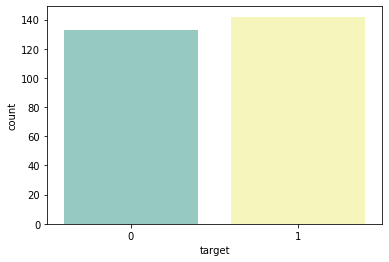

In [56]:
#The distribution of target value in train dataset
sns.countplot(train_df['target'], palette='Set3')

#The data is unbalanced with respect with target value
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0])),
print("There are {}% target values with 0".format(100 * train_df["target"].value_counts()[0]/train_df.shape[0]))

# scaling dataset

In [57]:
data= train_df 
y = data['target']
X = data.drop(['target', 'id'], axis=1)

#scaling dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
0,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,1.140193,-0.007402,-0.060412,-0.099714,-0.080746,-0.116116,-0.081089,-0.070647,-0.060412,-0.031007,-0.060412,-0.093635,-0.063121,-0.065440,-0.035503,-0.039157,-0.060412,-0.038669,-0.102274,-0.060412,-0.060412,-0.060412,0.059966,-0.057608,-0.060412,-0.065094,-0.060412,-0.060412,-0.060412,-0.060412,-0.047638,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.084397,-0.051633,-0.060412,-0.060412,-0.060412,-0.053585,-0.060412,-0.060412,-0.057942,-0.060412,-0.060412,-0.060412,-0.057170,-0.060412,-0.060310,-0.060411,-0.060412
1,-0.033795,-0.144136,-0.450950,0.831488,-0.373314,1.796722,-1.052703,-0.198712,-0.576338,-0.516283,-0.060413,0.013352,-0.239728,-0.024522,-0.043156,-0.206918,-0.060412,-0.069328,-0.060412,0.144665,-0.167931,0.001349,-0.063104,0.320556,-0.060412,-0.196764,-0.058959,-0.060412,-0.060412,-0.060412,-0.128651,-0.015201,-0.060412,-0.120265,-0.060412,-0.060412,-0.060412,-0.060412,-0.091252,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.084397,-0.030949,-0.060412,-0.060412,-0.060412,-0.036586,-0.060412,-0.060412,-0.080235,-0.060412,-0.060412,-0.060412,-0.080673,-0.060412,-0.060135,-0.060409,-0.060412
2,-1.195509,-0.144136,-0.450950,-0.083149,-1.151050,-1.071774,-0.384127,1.072123,-0.576338,-0.516283,-0.060413,-0.266884,0.012420,-0.036757,-0.009311,0.009210,-0.060412,-0.080025,-0.060412,-0.034280,-0.167931,-0.164187,-0.206070,-0.192050,-0.060412,-0.071394,0.138400,-0.060412,-0.060412,-0.060412,-0.128651,-0.020866,-0.060412,-0.120265,-0.060412,-0.060412,-0.060412,-0.060412,-0.091252,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.014095,-0.082216,-0.060412,-0.060412,-0.060412,-0.078718,-0.060412,-0.060412,-0.080235,-0.060412,-0.060412,-0.060412,-0.080673,-0.060412,-0.060568,-0.060414,-0.060412
3,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,-0.004161,-0.007402,-0.060412,-0.091704,-0.073128,-0.109627,-0.081089,-0.064117,-0.060412,-0.019660,-0.060412,-0.088782,-0.058099,-0.060708,-0.027330,-0.031831,-0.060412,-0.031094,-0.099206,-0.060412,-0.060412,-0.060412,-0.062766,-0.054604,-0.060412,-0.062450,-0.060412,-0.060412,-0.060412,-0.060412,-0.045549,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.084397,-0.050168,-0.060412,-0.060412,-0.060412,-0.052381,-0.060412,-0.060412,-0.056874,-0.060412,-0.060412,-0.060412,-0.056044,-0.060412,-0.060297,-0.060411,-0.060412
4,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,-0.004161,-0.007402,-0.060412,-0.093335,-0.074679,-0.110948,-0.081089,-0.065447,-0.060412,-0.021971,-0.060412,-0.089770,-0.059122,0.040844,-0.028994,-0.033323,-0.060412,-0.032636,-0.099831,-0.060412,-0.060412,-0.060412,-0.063380,-0.055215,-0.060412,-0.062988,-0.060412,-0.060412,-0.060412,-0.060412,-0.045974,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.038379,-0.050467,-0.060412,-0.060412,-0.060412,-0.052626,-0.060412,-0.060412,-0.057091,-0.060412,-0.060412,-0.060412,-0.056274,-0.060412,-0.060568,-0.060414,-0.060412


In [58]:
#splitting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)
X_train.head()

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55
69,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,-0.004161,-0.007402,-0.060412,-0.090054,-0.071559,-0.108290,-0.081089,-0.062772,-0.060412,-0.017322,-0.060412,-0.087782,-0.057064,-0.059733,-0.025646,-0.030322,-0.060412,-0.029533,-0.098573,-0.060412,-0.060412,-0.060412,-0.062146,-0.053985,-0.060412,-0.061905,-0.060412,-0.060412,-0.060412,-0.060412,-0.045118,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.037509,-0.049866,-0.060412,-0.060412,-0.060412,-0.052133,-0.060412,-0.060412,-0.056653,-0.060412,-0.060412,-0.060412,-0.055812,-0.060412,-0.060568,-0.060414,-0.060412
39,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,-0.004161,-0.007402,-0.060412,-0.090054,-0.071559,-0.108290,-0.081089,-0.062772,-0.060412,-0.017322,-0.060412,-0.087782,-0.057064,-0.059733,-0.025646,-0.030322,-0.060412,-0.029533,-0.098573,-0.060412,-0.060412,-0.060412,-0.062146,-0.053985,-0.060412,-0.061905,-0.060412,-0.060412,-0.060412,-0.060412,-0.045118,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.037509,-0.049866,-0.060412,-0.060412,-0.060412,-0.052133,-0.060412,-0.060412,-0.056653,-0.060412,-0.060412,-0.060412,-0.055812,-0.060412,-0.060568,-0.060414,-0.060412
95,-1.195509,-1.187225,-1.362796,1.746124,-0.373314,-1.071774,-0.384127,-0.198712,-0.576338,0.501479,-0.060413,-0.266884,0.542925,-0.251538,-0.081089,-0.206918,-0.060412,-0.267817,-0.060412,0.303704,-0.167931,0.159895,-0.066123,-0.192050,-0.060412,-0.067050,-0.061225,-0.060412,-0.060412,-0.060412,-0.128651,-0.017421,-0.060412,0.060804,-0.060412,-0.060412,-0.060412,-0.060412,-0.091252,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.084397,-0.082216,-0.060412,-0.060412,-0.060412,-0.078718,-0.060412,-0.060412,-0.043652,-0.060412,-0.060412,-0.060412,-0.080673,-0.060412,-0.060144,-0.060410,-0.060412
76,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.284449,-0.198712,-0.004161,-0.007402,-0.060412,-0.095874,-0.077094,-0.113006,-0.081089,-0.067517,-0.060412,-0.025568,-0.060412,-0.091309,-0.060714,-0.063172,-0.031585,-0.035646,-0.060412,-0.035038,-0.100803,-0.060412,-0.060412,-0.060412,-0.064335,-0.056168,-0.060412,-0.063826,-0.060412,-0.060412,-0.060412,-0.060412,-0.046637,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.084397,-0.050931,-0.060412,-0.060412,-0.060412,-0.027298,-0.060412,-0.060412,-0.057430,-0.060412,-0.060412,-0.060412,-0.056631,-0.060412,-0.060304,-0.060411,-0.060412
15,-0.033795,-0.144136,0.460897,-0.083149,0.404423,0.362474,0.953024,-0.198712,-0.004161,-0.007402,-0.060412,-0.095184,-0.076437,-0.112446,-0.081089,-0.066954,-0.060412,-0.024590,-0.060412,-0.090890,-0.060281,-0.062764,-0.030881,-0.035014,-0.060412,0.046805,-0.100539,-0.060412,-0.060412,-0.060412,-0.064075,-0.055909,-0.060412,-0.063599,-0.060412,-0.060412,-0.060412,-0.060412,-0.046457,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.060412,-0.038870,-0.050805,-0.060412,-0.060412,-0.060412,-0.052904,-0.060412,-0.060412,-0.057338,-0.060412,-0.060412,-0.060412,-0.056534,-0.060412,-0.060568,-0.060414,-0.060412


In [59]:
#size after scale and split
X_train.shape, X_test.shape

((192, 65), (83, 65))

In [0]:
#The scatter plot for train and test set for few of the features
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [0]:
#The scatter plot for 16 features
#features = ['var_0','var_1','var_2','var_5','var_6','var_9','var_11','var_12','var_13','var_16','var_18',
 #           'var_21','var_22','var_23','var_24','var_26']
#plot_feature_scatter(train_df[::20],test_df[::20], features)

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

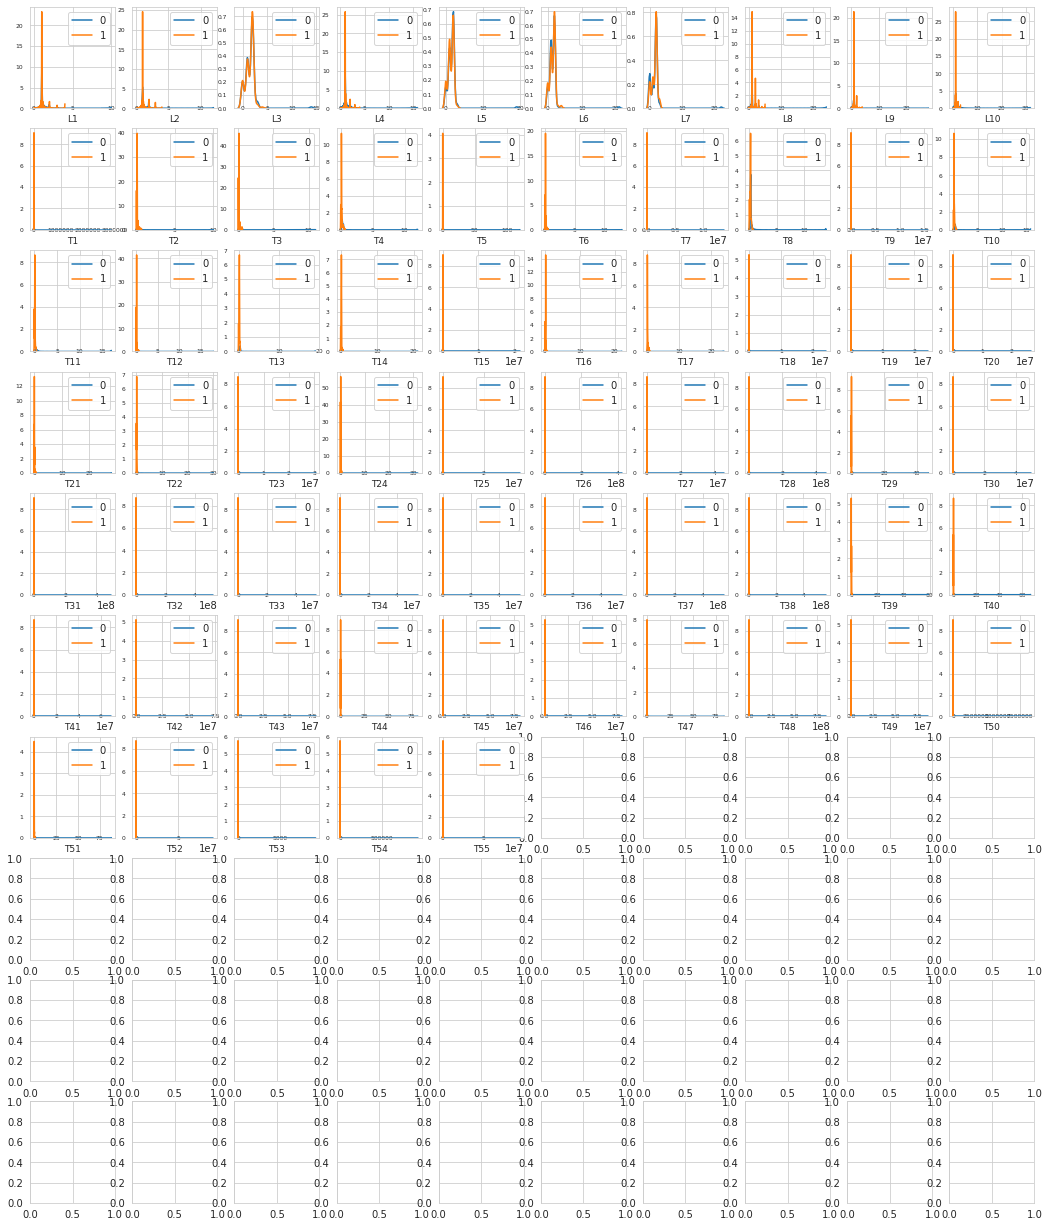

In [62]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

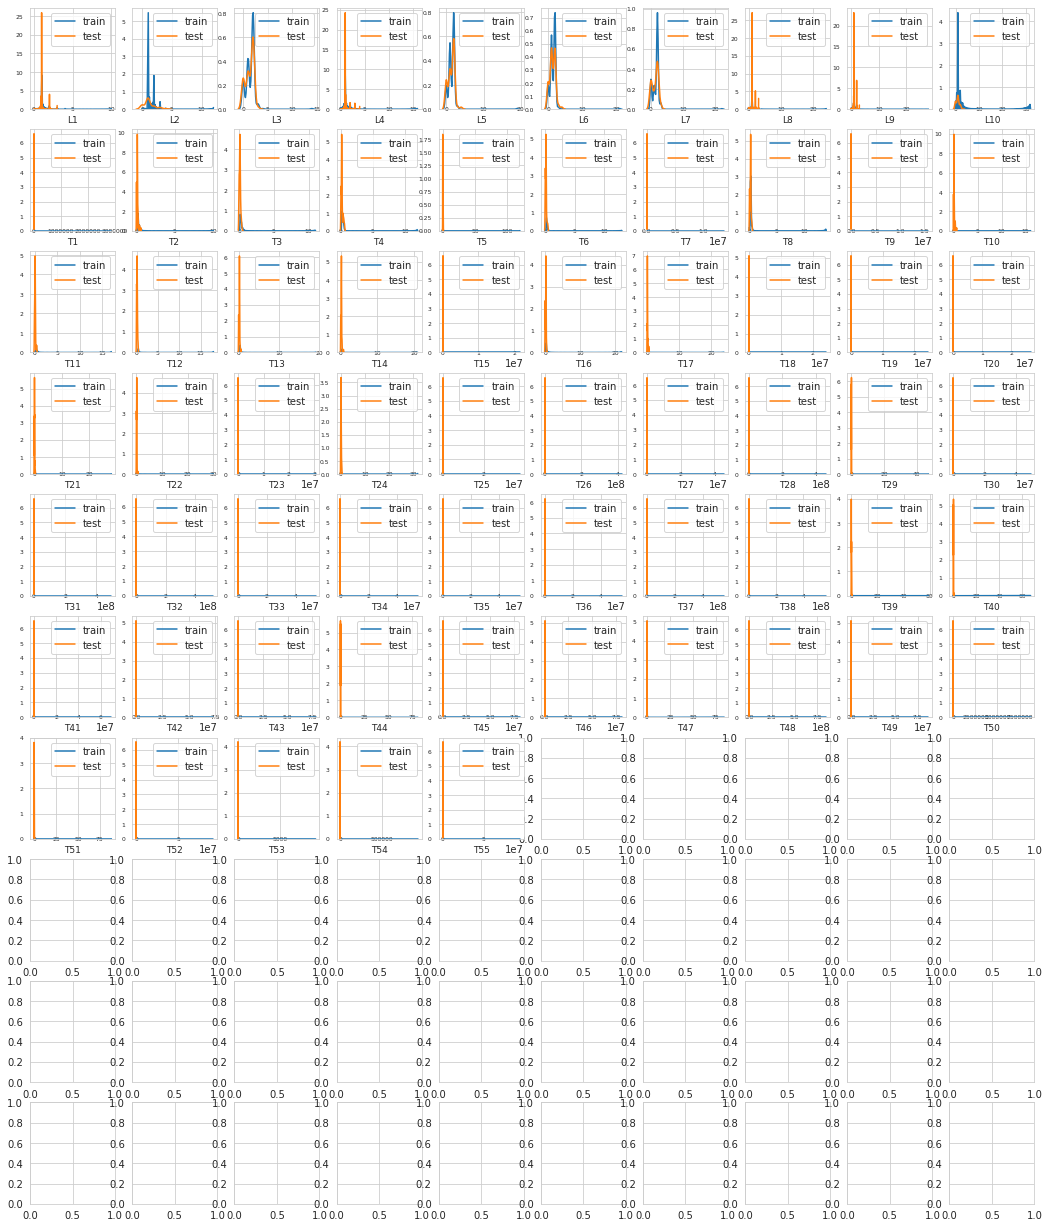

In [63]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

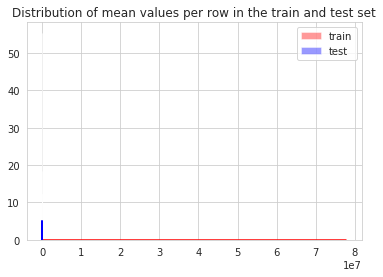

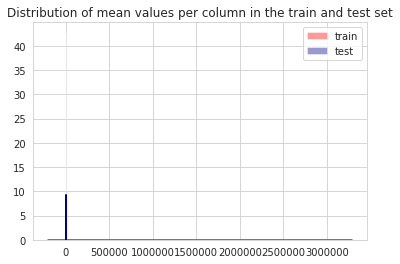

In [64]:
#The distribution of the mean values per row in the train & test set
#plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#The distribution of the mean values per column in the train & test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="red",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

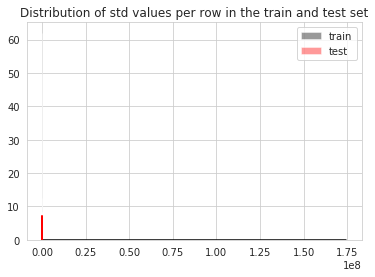

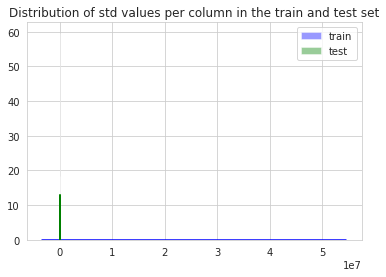

In [65]:
# The distribution of std values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

# The distribution of std values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

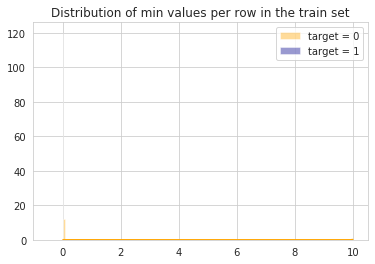

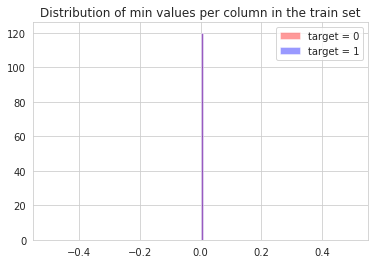

In [66]:
# The distribution of min values per row in the train and test set
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of min values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

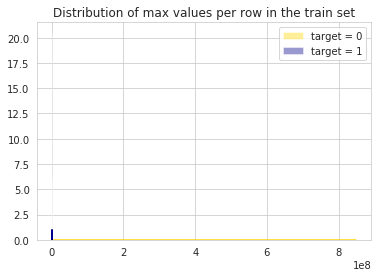

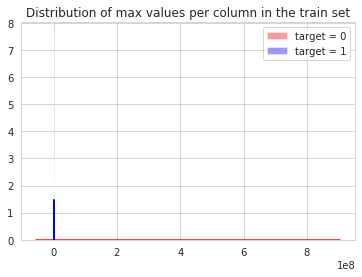

In [67]:
# The distribution of max values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of max values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

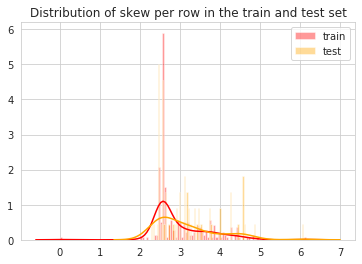

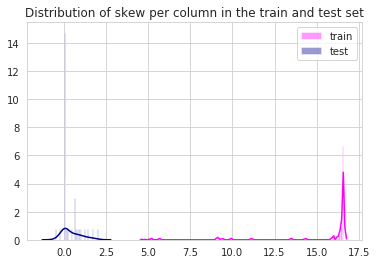

In [68]:
#Distribution of skew per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of skew per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

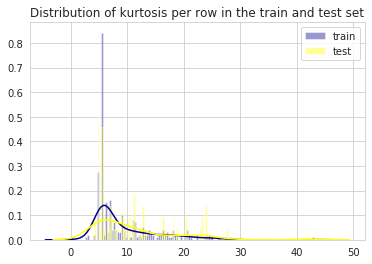

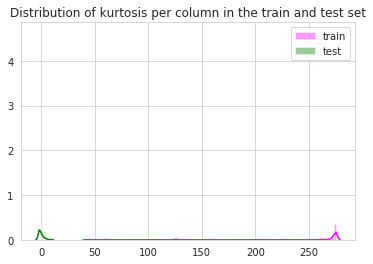

In [69]:
#Distribution of kurtosis per row in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of kurtosis per column in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()


# Correlation between the attributes

In [70]:
#Correlation between the attributes for train data
#Correlations in train attributes
train_attributes=train_df.columns.values[2:202]
train_correlations=train_df[train_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlations=train_correlations[train_correlations['level_0']!=train_correlations['level_1']]
train_correlations.head(10)

#print(train_correlations.head(10))
#print(train_correlations.tail(10))

,level_0,level_1,0
0,L3,L1,0.423890
1,L1,L3,0.423890
2,L1,L2,0.426960
3,L2,L1,0.426960
4,L2,L3,0.443428
5,L3,L2,0.443428
6,L1,L4,0.507212
7,L4,L1,0.507212
8,L3,L4,0.508400
9,L4,L3,0.508400


In [71]:
train_correlations.tail(10)

,level_0,level_1,0
4215,T19,T30,1.0
4216,T55,T30,1.0
4217,T19,T26,1.0
4218,T26,T19,1.0
4219,T30,T55,1.0
4220,T30,T19,1.0
4221,T38,T48,1.0
4222,T48,T38,1.0
4223,T26,T48,1.0
4224,T48,T26,1.0


In [72]:
#Correlation between the attributes for test data
#Correlations in test attributes
test_attributes=test_df.columns.values[1:201]
test_correlations=test_df[test_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
test_correlations=test_correlations[test_correlations['level_0']!=test_correlations['level_1']]
test_correlations.head(10)

#print(test_correlations.head(10))
#print(test_correlations.tail(10))

,level_0,level_1,0
0,T16,T47,0.000344
1,T47,T16,0.000344
2,T11,T34,0.000501
3,T35,T11,0.000501
4,T34,T11,0.000501
5,T33,T11,0.000501
6,T11,T55,0.000501
7,T45,T11,0.000501
8,T26,T11,0.000501
9,T11,T1,0.000501


In [0]:
test_correlations.tail(10)

# Correlation plot for train and test data

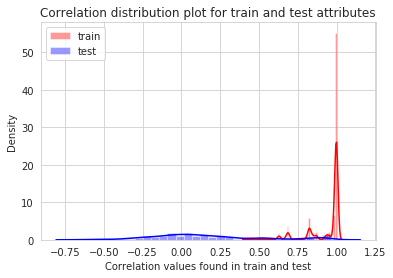

In [73]:
#Correlation plot for train and test data
# correlation between the train and test attributes is very very small
#it means that features are independent each other.
#Correlations in train data
train_correlations=train_df[train_attributes].corr()
train_correlations=train_correlations.values.flatten()
train_correlations=train_correlations[train_correlations!=1]
#Correlations in test data
test_correlations=test_df[test_attributes].corr()
test_correlations=test_correlations.values.flatten()
test_correlations=test_correlations[test_correlations!=1]

#plt.figure(figsize=(20,5))
#Distribution plot for correlations in train data
sns.distplot(train_correlations, color="Red", label="train")
#Distribution plot for correlations in test data
sns.distplot(test_correlations, color="Blue", label="test")
plt.xlabel("Correlation values found in train and test")
plt.ylabel("Density")
plt.title("Correlation distribution plot for train and test attributes")
plt.legend()

In [0]:
#Feature engineering
#Permutation variable importance measure in a random forest for classification
X=train_df.drop(columns=['id','target'],axis=1)
test=test_df.drop(columns=['id'],axis=1)
Y=train_df['target']

In [76]:
#build simple model to find features which are more important
#Split the training data
x_train,x_test,y_train, y_test = train_test_split(X, Y, random_state=42)

print('Shape of X_train :',x_train.shape)
print('Shape of X_test :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of X_train : (206, 65)
Shape of X_test : (69, 65)
Shape of y_train : (206,)
Shape of y_test: (69,)


In [77]:
#Split the train data using StratefiedKFold cross validator
#Training data
X=train_df.drop(['id','target'],axis=1)
Y=train_df['target']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True) #SPLITS=5
for train_index,test_index in cv.split(X,Y):
    x_train, x_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=Y.iloc[train_index], Y.iloc[test_index]

print('Shape of X_train :',x_train.shape)
print('Shape of X_valid :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_test.shape)

Shape of X_train : (220, 65)
Shape of X_valid : (55, 65)
Shape of y_train : (220,)
Shape of y_valid : (55,)


In [0]:
# Importing Classifier Modules
import datetime, time, json
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# XGB Classifier

In [79]:
 #XGB
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)
acc_xgb = round (metrics.accuracy_score(y_test, y_pred_xgb) *100, 2)
Precision_xgb= round (metrics.precision_score(y_test, y_pred_xgb) *100, 2)
Recall_xgb = round (metrics.recall_score(y_test, y_pred_xgb) *100, 2)
F1_xgb = round (metrics.f1_score(y_test, y_pred_xgb) *100, 2)
ROC_xgb= round (metrics.roc_auc_score(y_test, y_pred_xgb)* 100, 2)  

print("Accuracy for XGBClassifier is: {}".format(acc_xgb))
print("precision_score for XGBClassifier is: {}".format(Precision_xgb))
print("Recall_score for XGBClassifier is: {}".format(Recall_xgb))
print("F1_score for XGBClassifier is: {}".format(F1_xgb))
print("ROC for XGBClassifier is: {}".format(ROC_xgb))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:03:42.124423
Accuracy for XGBClassifier is: 56.36
precision_score for XGBClassifier is: 60.0
Recall_score for XGBClassifier is: 51.72
F1_score for XGBClassifier is: 55.56
ROC for XGBClassifier is: 56.63
Training ended at 2020-03-16 18:03:42.290633
Minutes elapsed: 0.002755


# MLPClassifier  

In [80]:
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier()  
mlp.fit(x_train, y_train) 
y_pred_mlp = mlp.predict(x_test)  


acc_mlp = round (metrics.accuracy_score(y_test, y_pred_mlp) *100, 2)
Precision_mlp= round (metrics.precision_score(y_test, y_pred_mlp) *100, 2)
Recall_mlp = round (metrics.recall_score(y_test, y_pred_mlp) *100, 2)
F1_mlp = round (metrics.f1_score(y_test, y_pred_mlp) *100, 2)
ROC_mlp= round (metrics.roc_auc_score(y_test, y_pred_mlp)* 100, 2)  

print("Accuracy for MLP is: {}".format(acc_mlp))
print("precision_score for MLP is: {}".format(Precision_mlp))
print("Recall_score for MLP is: {}".format(Recall_mlp))
print("F1_score for MLP is: {}".format(F1_mlp))
print("ROC for MLP is: {}".format(ROC_mlp))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:03:49.635351
Accuracy for MLP is: 54.55
precision_score for MLP is: 59.09
Recall_score for MLP is: 44.83
F1_score for MLP is: 50.98
ROC for MLP is: 55.11
Training ended at 2020-03-16 18:03:50.133371
Minutes elapsed: 0.008286


# Linear SVM

In [81]:
# linear SVM
print("Starting training at", datetime.datetime.now())
t0 = time.time()

linear_svc = LinearSVC(dual=False)
scores = cross_val_score(linear_svc, x_train, y_train, cv=3, scoring = "accuracy")
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
precision_linear_svc = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_linear_svc = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_linear_svc = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_linear_svc = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_linear_svc = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('linear SVM : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:03:53.957865
linear SVM : 
Precision: 0.0
Recall: 0.0
Accuracy: 45.45
f1 score: 0.0
ROC: 48.08
Training ended at 2020-03-16 18:03:54.000357
Minutes elapsed: 0.000704


### Naïve Bayes

In [82]:
# NB
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gaussian = GaussianNB()
scores = cross_val_score(gaussian, x_train, y_train, cv=3, scoring="accuracy")
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
precision_gaussian = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gaussian = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gaussian = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gaussian = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gaussian= round(roc_auc_score(y_test, Y_pred) * 100, 2)
print('NB : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:03:59.163557
NB : 
Precision: 52.73
Recall: 100.0
Accuracy: 52.73
f1 score: 69.05
ROC: 50.0
Training ended at 2020-03-16 18:03:59.203033
Minutes elapsed: 0.000631


# Logistic Regression

In [83]:
# Logistic Regression

print("Starting training at", datetime.datetime.now())
t0 = time.time()

logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, x_train, y_train, cv=3, scoring="accuracy")
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
precision_logreg = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_logreg = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_logreg = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_logreg = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_logreg = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Logistic Regression : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:05.653838
Logistic Regression : 
Precision: 0.0
Recall: 0.0
Accuracy: 45.45
f1 score: 0.0
ROC: 48.08
Training ended at 2020-03-16 18:04:05.792595
Minutes elapsed: 0.002303


# Decision Tree 

In [84]:
# Decision Tree Gini

print("Starting training at", datetime.datetime.now())
t0 = time.time()

decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, x_train, y_train, cv=3)
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
precision_tree_gini = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_tree_gini = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_tree_gini = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_tree_gini = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_tree_gini = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Desision tree : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:07.768816
Desision tree : 
Precision: 60.0
Recall: 31.03
Accuracy: 52.73
f1 score: 40.91
ROC: 53.98
Training ended at 2020-03-16 18:04:07.807498
Minutes elapsed: 0.000632


# Random Forest

In [86]:
#RandomForest
print("Starting training at", datetime.datetime.now())
t0 = time.time()

random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, x_train, y_train, cv=3)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
precision_random_forest = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_random_forest = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_random_forest = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_random_forest = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_random_forest = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("random forest : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:15.918540
random forest : 
Precision: 57.14
Recall: 55.17
Accuracy: 54.55
f1 score: 56.14
ROC: 54.51
Training ended at 2020-03-16 18:04:16.617224
Minutes elapsed: 0.011629


# Gradient Boosting

In [87]:
#GradientBoosting
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gbrt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, subsample=0.5)
scores = cross_val_score(gbrt, x_train, y_train, cv=3)
gbrt.fit(x_train, y_train)
Y_pred = gbrt.predict(x_test)
precision_gbrt = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gbrt = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gbrt = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gbrt = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gbrt = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Gradient Boosting Classifier : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:19.278440
Gradient Boosting Classifier : 
Precision: 57.89
Recall: 37.93
Accuracy: 52.73
f1 score: 45.83
ROC: 53.58
Training ended at 2020-03-16 18:04:21.480663
Minutes elapsed: 0.036691


#  Bagging Classifier with NB

In [88]:
# BaggingClassifier wiht NB
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

bag_nb = BaggingClassifier(GaussianNB(), n_estimators=100, n_jobs=1, bootstrap=True, random_state=1)
scores = cross_val_score(bag_nb, x_train, y_train, cv=3)
bag_nb.fit(x_train, y_train)
Y_pred = bag_nb.predict(x_test)
precision_bag_nb = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_bag_nb = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_bag_nb = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_bag_nb = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_bag_nb = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)

print("BaggingClassifier with nb : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:21.506651
BaggingClassifier with nb : 
Precision: 52.73
Recall: 100.0
Accuracy: 52.73
f1 score: 69.05
ROC: 50.0
Training ended at 2020-03-16 18:04:22.101436
Minutes elapsed: 0.009904


# AdaBoost

In [89]:
#AdaBoost
print("Starting training at", datetime.datetime.now())
t0 = time.time()

ada = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=300, learning_rate=0.2)
scores = cross_val_score(ada, x_train, y_train, cv=3)
ada.fit(x_train, y_train)
Y_pred = ada.predict(x_test)
precision_ada = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_ada = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_ada = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_ada = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_ada = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Ada Boosting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:24.752392
Ada Boosting : 
Precision: 65.62
Recall: 72.41
Accuracy: 65.45
f1 score: 68.85
ROC: 65.05
Training ended at 2020-03-16 18:04:27.057040
Minutes elapsed: 0.038405


# # Voting classifier

In [90]:
# Voting classifier
print("Starting training at", datetime.datetime.now())
t0 = time.time()
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lsvm', linear_svc), ('Logistic_Regression', logreg), ('rf', random_forest), ('bd', bag_nb), ('NB', gaussian)],
                              voting='hard')
scores = cross_val_score(voting_clf, x_train, y_train, cv=3)
voting_clf.fit(x_train, y_train)
Y_pred = voting_clf.predict(x_test)
precision_voting = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_voting = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_voting = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_voting = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_voting = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("votting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 18:04:27.639479
votting : 
Precision: 59.09
Recall: 44.83
Accuracy: 54.55
f1 score: 50.98
ROC: 55.11
Training ended at 2020-03-16 18:04:29.209015
Minutes elapsed: 0.026154


In [91]:
comparison = pd.DataFrame({
    'Model': ['XGB','MLP','SVM', 'NB', 'LR', 'DT ','RF',
              'GD', 'Bagging with NB', 'Ada Boosting', 'Voting'],
    'Precision': [Precision_xgb,Precision_mlp,precision_linear_svc, precision_gaussian, precision_logreg,
                  precision_tree_gini, precision_random_forest, precision_gbrt,
                  precision_bag_nb, precision_ada, precision_voting ],
    'Recall': [Recall_xgb, Recall_mlp, recall_linear_svc, recall_gaussian, recall_logreg,
                  recall_tree_gini, recall_random_forest, recall_gbrt,
                  recall_bag_nb, recall_ada, recall_voting],
    'F1_score': [F1_xgb, F1_mlp,f1score_linear_svc, f1score_gaussian, f1score_logreg,
                  f1score_tree_gini,f1score_random_forest, f1score_gbrt,
                  f1score_bag_nb, f1score_ada, f1score_voting],
        'ROC': [ROC_xgb,ROC_mlp, ROC_linear_svc, ROC_gaussian, ROC_logreg,
                  ROC_tree_gini, ROC_random_forest, ROC_gbrt,
                  ROC_bag_nb, ROC_ada, ROC_voting],
    'Accuracy': [acc_xgb,acc_mlp, accuracy_linear_svc, accuracy_gaussian, accuracy_logreg,
                  accuracy_tree_gini, accuracy_random_forest, accuracy_gbrt,
                   accuracy_bag_nb, accuracy_ada, accuracy_voting]
})
comparison

,Model,Precision,Recall,F1_score,ROC,Accuracy
0,XGB,60.00,51.72,55.56,56.63,56.36
1,MLP,59.09,44.83,50.98,55.11,54.55
2,SVM,0.00,0.00,0.00,48.08,45.45
3,NB,52.73,100.00,69.05,50.00,52.73
4,LR,0.00,0.00,0.00,48.08,45.45
5,DT,60.00,31.03,40.91,53.98,52.73
6,RF,57.14,55.17,56.14,54.51,54.55
7,GD,57.89,37.93,45.83,53.58,52.73
8,Bagging with NB,52.73,100.00,69.05,50.00,52.73
9,Ada Boosting,65.62,72.41,68.85,65.05,65.45


In [92]:
print(comparison)
comparison.plot(x='Model', kind=Model	Precision	Recall	F1_score	ROC	Accuracy
0	XGB	77.06	72.21	74.55	75.35	75.35
1	MLP	69.94	66.46	68.16	68.95	68.95
2	SVM	77.98	77.61	77.79	77.84	77.84
3	NB	79.98	80.02	80.00	80.00	80.00
4	LR	76.80	77.33	77.06	76.98	76.98
5	DT	59.59	59.99	59.79	59.65	59.65
6	RF	66.86	54.22	59.88	63.67	63.67
7	GD	80.57	77.90	79.22	79.56	79.56
8	Bagging with NB	79.95	79.97	79.96	79.96	79.96
9	Ada Boosting	79.59	75.86	77.68	78.20	78.20
10	Voting	79.62	78.45	79.03	79.19	79.19'bar')
plt.show()

SyntaxError: ignored

In [93]:
#using random forests
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
predictionRFC = rfc.predict_proba(x_test)
predictionRFC

array([[0.28      , 0.72      ],
       [0.715     , 0.285     ],
       [0.47      , 0.53      ],
       [0.635     , 0.365     ],
       [0.21305303, 0.78694697],
       [0.79      , 0.21      ],
       [0.44      , 0.56      ],
       [0.53      , 0.47      ],
       [0.41571429, 0.58428571],
       [0.49196224, 0.50803776],
       [0.30366667, 0.69633333],
       [0.57848593, 0.42151407],
       [0.49196224, 0.50803776],
       [0.45      , 0.55      ],
       [0.49196224, 0.50803776],
       [0.65      , 0.35      ],
       [0.43      , 0.57      ],
       [0.41      , 0.59      ],
       [0.23071569, 0.76928431],
       [0.90428571, 0.09571429],
       [0.49196224, 0.50803776],
       [0.59208333, 0.40791667],
       [0.19402778, 0.80597222],
       [0.4979982 , 0.5020018 ],
       [0.49196224, 0.50803776],
       [0.59444444, 0.40555556],
       [0.8055    , 0.1945    ],
       [0.66      , 0.34      ],
       [0.53      , 0.47      ],
       [0.73210714, 0.26789286],
       [0.

In [94]:
#probability that the mice gender might be male according to the body analysis (target class 1)
prob = [1 - item[0] for item in predictionRFC] 
prob[:5]

[0.72, 0.28500000000000003, 0.53, 0.365, 0.7869469696969698]